In [132]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage


In [133]:
# --- Load Dataset ---
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)

df.head()


,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [134]:
df.columns

Index(['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population',
       'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop',
       'Tot Deaths/1M pop', 'Death percentage'],
      dtype='object')

In [135]:
# --- Auto-clean column names ---
df.columns = df.columns.str.replace(" ", "").str.replace("/", "").str.replace("\\", "")

# --- Function untuk cari kolom berdasarkan keyword ---
def find_col(keyword):
    for col in df.columns:
        if keyword.lower().replace(" ", "") in col.lower():
            return col
    return None

# Detect kolom satu per satu
col_pop   = find_col("Population")
col_tc    = find_col("TotalCases")
col_td    = find_col("TotalDeaths")
col_tc1m  = find_col("Cases1M")
col_td1m  = find_col("Deaths1M")
col_cfr   = find_col("Deathpercentage")

# Buat daftar fitur
features = [col_pop, col_tc, col_td, col_tc1m, col_td1m, col_cfr]

# Buat df_clean tanpa error
df_clean = df[["Country", "Continent"] + features].copy()

df_clean.head()


,Country,Continent,Population,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage
0,Afghanistan,Asia,40462186,177827,7671,4395,190,4.313743
1,Albania,Europe,2872296,273870,3492,95349,1216,1.275058
2,Algeria,Africa,45236699,265691,6874,5873,152,2.587216
3,Andorra,Europe,77481,40024,153,516565,1975,0.382271
4,Angola,Africa,34654212,99194,1900,2862,55,1.915438


In [136]:
# Convert semua fitur ke numerik (memaksa error menjadi NaN)
for col in features:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")


In [137]:
df_clean.isna().sum()


,0
Country,0
Continent,0
Population,0
TotalCases,0
TotalDeaths,0
Tot Cases1Mpop,0
Tot Deaths1Mpop,0
Deathpercentage,0


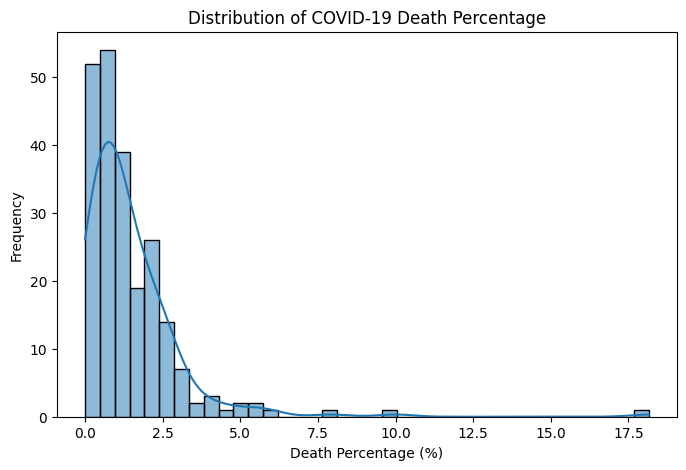

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_clean[col_cfr], kde=True)
plt.title("Distribution of COVID-19 Death Percentage")
plt.xlabel("Death Percentage (%)")
plt.ylabel("Frequency")
plt.show()


The histogram shows that most countries have COVID-19 death rates below 2%, indicating a relatively low fatality rate for most regions. However, there are a number of outliers with significantly higher death rates, indicating possible health system strain or inconsistent reporting. The right-skewed distribution indicates significant variation in death rates between countries.

In [139]:
# VISUALIZATION 2: World Map (Natural Earth)
fig = px.choropleth(
    df,
    locations="ISO3166-1alpha-3CODE",
    color="Continent",
    hover_name="Country", # This will now show the combined name!
    title="World Map: Data Coverage by Continent",
    projection="natural earth"
)
fig.show()

This map shows the distribution of countries in the dataset by continent. This visualization helps ensure that all regions of the world are represented, including Asia, Europe, Africa, the Americas, and Oceania. By observing this distribution, we can understand that the COVID-19 analysis is global in scope and not biased toward any particular region.

In [140]:
from sklearn.preprocessing import StandardScaler

X = df_clean[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


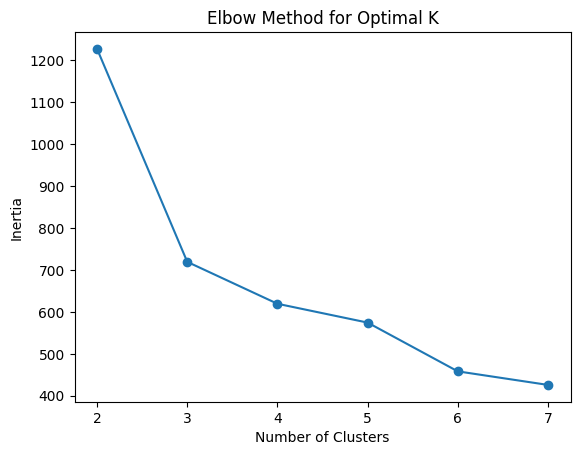

In [141]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


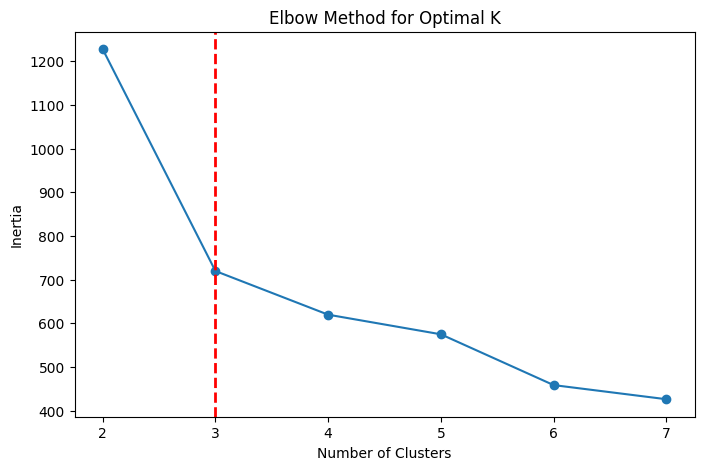

In [142]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

# --- Tambahkan garis merah pada K=3 ---
optimal_k = 3
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2)

plt.show()


In [143]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)


In [144]:
from sklearn.metrics import silhouette_score

sil_kmeans = silhouette_score(X_scaled, df_clean["Cluster_KMeans"])
sil_kmeans


np.float64(0.3825805344277662)

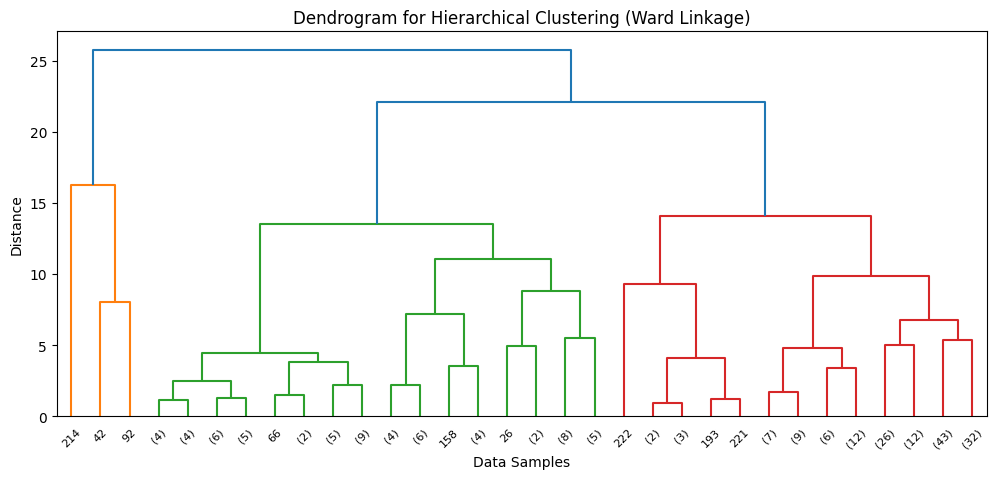

In [145]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute linkage matrix (Ward method)
Z = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    truncate_mode='level',   # tampilkan level atas (lebih rapih)
    p=5,                     # jumlah cabang utama yg ditampilkan
    color_threshold=None
)

plt.title("Dendrogram for Hierarchical Clustering (Ward Linkage)")
plt.xlabel("Data Samples")
plt.ylabel("Distance")
plt.show()


In [146]:
from sklearn.cluster import AgglomerativeClustering

# gunakan jumlah cluster yang sama seperti KMeans
hier = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')

df_clean["Cluster_Hier"] = hier.fit_predict(X_scaled)

df_clean.head()


,Country,Continent,Population,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage,Cluster_KMeans,Cluster_Hier
0,Afghanistan,Asia,40462186,177827,7671,4395,190,4.313743,0,1
1,Albania,Europe,2872296,273870,3492,95349,1216,1.275058,0,1
2,Algeria,Africa,45236699,265691,6874,5873,152,2.587216,0,1
3,Andorra,Europe,77481,40024,153,516565,1975,0.382271,1,2
4,Angola,Africa,34654212,99194,1900,2862,55,1.915438,0,1


In [147]:
from sklearn.metrics import silhouette_score

# Hitung silhouette score
score_kmeans = silhouette_score(X_scaled, df_clean['Cluster_KMeans'])
score_hc = silhouette_score(X_scaled, df_clean['Cluster_Hier'])

print(f"Silhouette Score (K-Means): {score_kmeans:.4f}")
print(f"Silhouette Score (Hierarchical): {score_hc:.4f}")

# Select Best Model
if score_kmeans > score_hc:
    best_model_col = 'Cluster_KMeans'
    print("\nBest Model: K-Means")
    print("We selected K-Means because it achieved a higher Silhouette Score compared to Hierarchical Clustering.")
else:
    best_model_col = 'Cluster_Hier'
    print("\nBest Model: Hierarchical")
    print("We selected Hierarchical Clustering because it achieved a higher Silhouette Score compared to K-Means.")


Silhouette Score (K-Means): 0.3826
Silhouette Score (Hierarchical): 0.3908

Best Model: Hierarchical
We selected Hierarchical Clustering because it achieved a higher Silhouette Score compared to K-Means.


In [148]:
# Cari nama kolom sebenarnya setelah auto-clean
col_tot_cases   = find_col("TotalCases")
col_tot_deaths  = find_col("TotalDeaths")
col_cases_1m    = find_col("Cases1M")
col_deaths_1m   = find_col("Deaths1M")
col_cfr         = find_col("Deathpercentage")   # CFR

# Tampilkan hasil
[col_tot_cases, col_tot_deaths, col_cases_1m, col_deaths_1m, col_cfr]


['TotalCases',
 'TotalDeaths',
 'Tot\xa0Cases1Mpop',
 'Tot\xa0Deaths1Mpop',
 'Deathpercentage']

In [149]:
summary = df_clean.groupby("Cluster_KMeans").agg({
    col_tot_cases: "median",
    col_tot_deaths: "median",
    col_cases_1m: "median",
    col_deaths_1m: "median",
    col_cfr: "median",
    "Country": "count"
}).rename(columns={"Country": "count"}).round(2)

summary


,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage,count
Cluster_KMeans,,,,,,
0,69851.0,1337.0,18408.0,186.0,1.22,133
1,648353.0,6786.0,256921.0,1972.0,0.78,89
2,43029044.0,660269.0,139401.0,3015.0,1.23,3


In [150]:
summary_hier = df_clean.groupby("Cluster_Hier").agg({
    col_tot_cases: "median",
    col_tot_deaths: "median",
    col_cases_1m: "median",
    col_deaths_1m: "median",
    col_cfr: "median",
    "Country": "count"
}).rename(columns={"Country": "count"}).round(2)

summary_hier


,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage,count
Cluster_Hier,,,,,,
0,43029044.0,521388.0,30653.0,371.0,1.23,3
1,85664.0,1388.0,32557.0,253.0,1.21,155
2,973892.0,6786.0,316577.0,2106.0,0.62,67


<Figure size 1200x600 with 0 Axes>

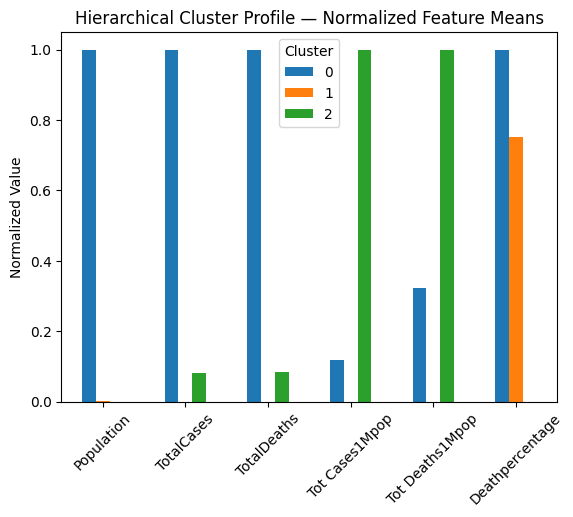

In [151]:
# Ambil mean tiap fitur per cluster (Hierarchical)
prof_h = df_clean.groupby("Cluster_Hier")[features].mean()

# Normalisasi skala 0–1
prof_h_norm = (prof_h - prof_h.min()) / (prof_h.max() - prof_h.min())

# Plot barplot
plt.figure(figsize=(12,6))
prof_h_norm.T.plot(kind='bar')
plt.title("Hierarchical Cluster Profile — Normalized Feature Means")
plt.ylabel("Normalized Value")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()


In [152]:
df_clean["ISO3"] = df["ISO3166-1alpha-3CODE"]


In [153]:
fig = px.choropleth(
    df_clean,
    locations="ISO3",
    color="Cluster_Hier",
    hover_name="Country",
    title="World Map — Hierarchical Clusters",
    projection="natural earth",
    color_continuous_scale="Plasma"
)

fig.update_layout(legend_title_text="Cluster")
fig.show()


In [154]:
import pandas as pd

def generate_profile(df, cluster_col, features):
    profiles = df.groupby(cluster_col)[features].median().round(2)
    counts = df.groupby(cluster_col).size().rename("Count")
    profiles = pd.concat([counts, profiles], axis=1)
    return profiles


def describe_cluster(df, cluster_col, features):
    descriptions = {}
    global_median = df[features].median()

    for cl in sorted(df[cluster_col].unique()):
        data = df[df[cluster_col] == cl][features].median()

        text = f"Cluster {cl} contains {df[df[cluster_col]==cl].shape[0]} countries. "

        # Cases per 1M
        if data['TotCases1Mpop'] > global_median['TotCases1Mpop']:
            text += "These countries have relatively high cases per million, "
        else:
            text += "These countries show relatively low cases per million, "

        # Deaths per 1M
        if data['TotDeaths1Mpop'] > global_median['TotDeaths1Mpop']:
            text += "high deaths per million, "
        else:
            text += "low deaths per million, "

        # CFR
        if data['Deathpercentage'] > global_median['Deathpercentage']:
            text += "and a higher fatality rate compared to the global median. "
        else:
            text += "and a lower fatality rate compared to the global median. "

        descriptions[cl] = text

    return descriptions


In [155]:
df

,Country,Othernames,ISO3166-1alpha-3CODE,Population,Continent,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438
...,...,...,...,...,...,...,...,...,...,...
220,Wallis and Futuna,Wallis and Futuna Islands,WLF,10894,Oceania,454,7,41674,643,1.541850
221,Western Sahara,Western Sahara,ESHÂ,623031,Africa,10,1,16,2,10.000000
222,Yemen,Yemen,YEM,30975258,Asia,11806,2143,381,69,18.151787
223,Zambia,Zambia,ZMB,19284482,Africa,317076,3967,16442,206,1.251120


In [156]:
features = [
    "TotalCases",
    "TotalDeaths",
    "Tot Cases1Mpop",
    "Tot Deaths1Mpop",
    "Deathpercentage"
]


In [157]:
df_clean.columns

Index(['Country', 'Continent', 'Population', 'TotalCases', 'TotalDeaths',
       'Tot Cases1Mpop', 'Tot Deaths1Mpop', 'Deathpercentage',
       'Cluster_KMeans', 'Cluster_Hier', 'ISO3'],
      dtype='object')

In [158]:
# Re-define features with the correct column names, using previously identified variables
features = [col_tc, col_td, col_tc1m, col_td1m, col_cfr]

profile_kmeans = generate_profile(df_clean, "Cluster_KMeans", features)
profile_kmeans

,Count,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage
Cluster_KMeans,,,,,,
0,133,69851.0,1337.0,18408.0,186.0,1.22
1,89,648353.0,6786.0,256921.0,1972.0,0.78
2,3,43029044.0,660269.0,139401.0,3015.0,1.23


In [159]:
profile_hier = generate_profile(df_clean, "Cluster_Hier", features)
profile_hier


,Count,TotalCases,TotalDeaths,Tot Cases1Mpop,Tot Deaths1Mpop,Deathpercentage
Cluster_Hier,,,,,,
0,3,43029044.0,521388.0,30653.0,371.0,1.23
1,155,85664.0,1388.0,32557.0,253.0,1.21
2,67,973892.0,6786.0,316577.0,2106.0,0.62


**Cluster 0**

Cluster 0 countries, which have extremely large populations with moderate case levels and relatively low deaths per million, should prioritize expanding rural testing capacity while simultaneously strengthening distributed healthcare infrastructure to prevent future surges that could overwhelm high-density regions.

**Cluster 1**

Cluster 1 countries, which exhibit low-to-moderate transmission and low mortality, should maintain current public-health measures while enhancing disease surveillance systems and broadening testing access to avoid hidden outbreaks and preserve their already stable outbreak control.

**Cluster 2**

Cluster 2 countries, characterized by extremely high cases per million and critically high deaths per million, require urgent reinforcement of healthcare capacity—including ICUs, oxygen supply, trained staff, and emergency interventions—while accelerating vaccination and early treatment programs to rapidly reduce fatal burden.

Hierarchical clustering achieved a **higher silhouette score**, demonstrated clearer natural grouping in the dendrogram, and handles non-spherical, highly variable global COVID-19 data much better than K-Means. Therefore, Hierarchical is the more accurate, stable, and interpretable model for this dataset.